In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd /content/gdrive/MyDrive/pos

/content/gdrive/MyDrive/pos


In [3]:
ls

In [4]:
### Library functions
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
import networkx as nx
import matplotlib.pyplot as plt
import random 
from matplotlib import animation
import networkx.algorithms.centrality as nx_centrality
from collections import deque
from matplotlib import animation
import math

# Dataset

## Training dataset

The global parameters of the generate_random_graph function:
1. FAKE_DIFF_ITER: the fake nodes diffusion iteration
2. FAKE_SEED_NUM: the initial fake seed set number
3. NODE_NUM: the graph nodes number
4. EDGE_NUM: the graph edges number 
5. M_INDEX: the generate graph method index

In [5]:
def generate_random_graph(difusion_iteration, method_index,fake_seed_num, num_nodes , num_edges , probability = 0.5,m = 2, radius = None, k_nearest_neighbor = None, degree = None, seed = None):
    random_graph = nx.Graph()
    if method_index == 0:
        random_graph = nx.gnm_random_graph(num_nodes, num_edges)

    elif method_index == 1:
        random_graph = nx.erdos_renyi_graph(num_nodes, probability)

    elif method_index == 2:
         # m means the edges number from the create point to existing point
        random_graph = nx.barabasi_albert_graph(num_nodes, m)

    elif method_index == 3:
        random_graph = nx.watts_strogatz_graph(num_nodes, k_nearest_neighbor, probability)
#     elif method_index == 4:
#         random_graph=nx.gnc_graph(num_nodes)

#     elif method_index == 4:
#         random_graph = nx.random_geometric_graph(num_nodes, radius)   
        
#     elif method_index == 5:
#         random_graph = nx.random_regular_graph(degree, num_nodes)

#     elif method_index == 7:
#         #p1 = nodes in the tree connected,  p2 = nodes in the tree body connected
#         random_graph = nx.random_lobster(num_nodes, probability, probability)

#     elif method_index == 8:
#         p = probability # probability connected with its nearest neighbor
#         q = probability # probability connected with other nodes
#         random_graph = nx.newman_watts_strogatz_graph(num_nodes, p, q)

#     elif method_index == 9:
#         random_graph = nx.create_powerlaw_cluster_graph(num_nodes, k_nearest_neighbor, probability, seed=seed)

#     elif method_index == 10:
#         # A random maximal planar graph is a graph in which every possible edge that can be added without creating a cycle is included, 
#         # resulting in a planar graph with the maximum number of edges. 
#         random_graph = nx.random_maximal_planar_graph(num_nodes)

#     elif method_index == 11:
#         random_graph = nx.random_threshold_graph(num_nodes, probability)

#     elif method_index == 12:
#         random_graph = nx.create_forest_fire_graph(num_nodes, probability, probability, seed=seed)

#     elif method_index == 13:
#         k = k_nearest_neighbor # This k is different with KNN, it generates a scale-free network where new nodes are added with k initial edges
#         random_graph = nx.extended_barabasi_albert_graph(num_nodes, k, probability)


#     elif method_index == 15:
#         # lollipop graph
#         m = num_nodes // 2  # Number of nodes in the complete graph
#         n = num_nodes - m - 1  # Number of nodes in the cycle graph

#         G_complete = nx.complete_graph(m)
#         G_cycle = nx.cycle_graph(n)

#         # Connect the complete graph and cycle graph
#         G_complete.add_edge(m-1, m)
#         random_graph = nx.compose(G_complete, G_cycle)
    
    
    for (u,v) in random_graph.edges:
        if FIXED == True:
            random_graph.edges[u, v]["weight"] = PROBABILITY
        else:
            random_graph.edges[u, v]["weight"] =  random.uniform(0,1)
    for node in random_graph.nodes():
        random_graph.nodes[node]['state'] = 0 # 0初始状态；1:true；2:fake
    node_number = random_graph.number_of_nodes()
    start_node_index = [0] *fake_seed_num
    index_range = range(0,  node_number)
    fake_seed_set = random.sample(index_range, fake_seed_num)
    fake_active_nodes = fake_seed_set.copy()
    fake_nodes_set = fake_seed_set.copy()
    for _ in range(difusion_iteration):
        temp_fake = []
        for v in fake_active_nodes:
            for nbr in random_graph.neighbors(v): 
                if random_graph.nodes[nbr]['state'] == 0 : 
                    edge_data = random_graph.get_edge_data(v, nbr)
                    if random.uniform(0, 1) < edge_data['weight']:
                        fake_nodes_set.append(nbr)
                        temp_fake.append(nbr)
                        random_graph.nodes[nbr]['state'] = 2
        fake_active_nodes = temp_fake.copy()
        temp_fake.clear()    
    for node in fake_nodes_set:
        random_graph.nodes[node]['state'] = 2
        
    return random_graph,fake_active_nodes,fake_seed_set,fake_nodes_set


## Create and normalize test data

In [ ]:
# !pip install scanpy

In [ ]:
import scanpy as sc 
import scipy as sp
import scipy.sparse  # call as sp.sparse

# filename_ca_HepTh = r"D:\course (Kou Hari)\2023 semaster 1\COMP5703 Capstone\data\ca-HepTh.mtx"
# filename_ca_GrQc = r"D:\course (Kou Hari)\2023 semaster 1\COMP5703 Capstone\data\ca-GrQc.mtx"
# filename_tech_p2p_gnutella = r"D:\course (Kou Hari)\2023 semaster 1\COMP5703 Capstone\data\tech-p2p-gnutella.mtx"
filename_ca_HepTh = 'ca-HepTh.mtx'
filename_ca_GrQc = 'ca-GrQc.mtx'
filename_tech_p2p_gnutella = 'tech-p2p-gnutella.mtx'

In [ ]:
def read_graph(filename):
    adata = sc.read(filename)
    G = nx.from_scipy_sparse_array(adata.X, create_using=nx.MultiGraph)
    print("node number:",G.number_of_nodes())
    print("edge number:",G.number_of_edges())
    return G, G.number_of_nodes(), G.number_of_edges()

In [ ]:
G_ca_HepTh,N_ca_HepTh,E_ca_HepTh= read_graph(filename_ca_HepTh)

node number: 9877
edge number: 25998


In [ ]:
G_ca_GrQc,N_ca_GrQc,E_ca_GrQc = read_graph(filename_ca_GrQc)

node number: 5242
edge number: 14496


In [ ]:
G_tech_p2p_gnutella,N_tech_p2p_gnutella,E_tech_p2p_gnutella = read_graph(filename_tech_p2p_gnutella)

node number: 62561
edge number: 147878


In [6]:
def normalization_graph(graph):
    graph_node_number = graph.number_of_nodes()
    graph_edge_number = graph.number_of_edges()
    for node in graph.nodes():
        graph.nodes[node]['state'] = 0
    for (u,v) in graph.edges:
        graph.edges[u,v]['weight'] = random.uniform(0,1)
    return graph,graph_node_number,graph_edge_number

In [7]:
def fake_nodes_diffusion(graph,fake_seed_num,iteration):
    node_number = graph.number_of_nodes()
    start_node_index = [0] *fake_seed_num
    index_range = range(0,  node_number)
    fake_seed_set = random.sample(index_range, fake_seed_num)
    fake_active_nodes = fake_seed_set.copy()
    fake_nodes_set = fake_seed_set.copy()
    for node in fake_seed_set:
        graph.nodes[node]['state'] = 2
    #fake news diffusion
    for _ in range(iteration):
        temp_fake = []
        for v in fake_active_nodes:
            for nbr in graph.neighbors(v): 
                if graph.nodes[nbr]['state'] == 0 : 
                    edge_data = graph.get_edge_data(v, nbr)
                    if random.uniform(0, 1) < edge_data['weight']:
                        fake_nodes_set.append(nbr)
                        temp_fake.append(nbr)
                        graph.nodes[nbr]['state'] = 2
        fake_active_nodes = temp_fake.copy()  
    for node in fake_nodes_set:
        random_graph.nodes[node]['state'] = 2
    return graph,fake_active_nodes

In [8]:
def statistic_draw_graph(Graph,draw = False):
    color_list = []
    fake = 0
    true = 0
    normal = 0
    for node in Graph.nodes():
        if Graph.nodes[node]['state'] == 0:
            normal += 1
            color_list.append('blue')
        elif Graph.nodes[node]['state'] == 1:
            true += 1
            color_list.append('green')
        elif Graph.nodes[node]['state'] == 2:
            fake += 1
            color_list.append('red')
    print("normal nodes number:",normal)
    print("true nodes number:",true)
    print("fake nodes number:",fake)
    print("the edge of graph:",Graph.number_of_edges())
    #nx.draw(Graph, node_color= color_list) 
    if draw:
        nx.draw_circular(Graph, node_color= color_list)
        plt.show()

# Environment Class

The global parameters in the Environment Class:
1. ITERATION: control the diffusion times during the true and fake nodes antagonistic process
2. MAX_STEP: control the max step of this epoch
3. SEED_SIZE: the initial size of the seed set, the initial parameters of Env class.

The input variable of the Env() class:
1. graph: the training graph or testing graph
2. seed_size: SEED_SIZE;the initial size of the seed set
3. fake_set: the initial fake

The functions in the Env class:
1. reset: reset the parameters
2. step: the experiment excuation progress
3. select_initial_seeds: select the initial seed randomly
4. select_initial_seeds_rules: select the intial seed set according to different criterion
5. add_seed: add the seed nodes according to the action number from the agent
6. get_state: get the current state of the graph
7. diffusion_process: the procees of the true and fake nodes antagonistic
8. get_image: draw the image of the graph

In [9]:
class Env():
    def __init__(self, graph,seed_size,fake_set):
        self.graph_initial = graph
        self.seed_size = seed_size
        self.seed_set = []
        self.fake_set = fake_set
        self.state = None
        self.reset()

    def reset(self):
        #select the seed set:
        self.graph = self.graph_initial.copy()
        self.step_count = 0
        self.add_number = 0
        self.seed_set, action = self.select_initial_seeds_rules(self.graph,self.seed_size)
        self.true_active_nodes = self.seed_set.copy()
        self.fake_active_nodes = self.fake_set.copy()
        self.state = self.get_state()
        return self.state, action
    
    def step(self,action):
        count_state0 = 0
        for node in self.graph.nodes():
            if self.graph.nodes[node]['state'] == 0:
                count_state0 += 1
        if action > 0 and (len(self.seed_set) + ADD_SEED_NUMBER <= self.graph.number_of_nodes()) and count_state0 >= ADD_SEED_NUMBER:
            self.add_number += 1
            centrality_methods = ["None", "random", "degree", "closeness", "betweenness", "eigenvector"]
            centrality_method = centrality_methods[action]
            self.seed_set = self.add_seed(self.graph,self.seed_set,action,ADD_SEED_NUMBER)
            if(self.true_active_nodes[-ADD_SEED_NUMBER:]!= self.seed_set[-ADD_SEED_NUMBER:]):
                self.true_active_nodes.extend(self.seed_set[-ADD_SEED_NUMBER:])
        self.graph,self.true_active_nodes,self.fake_active_nodes = self.diffusion_process(self.graph,
                                                                                     self.true_active_nodes,
                                                                               self.fake_active_nodes,ITERATION)
        #print("current image:")
        #self.get_image(self.graph)
        
        # terminal condition                                                                    
        all_true_nodes = []
        all_fake_nodes = []
        normal_nodes= []                                                                             
        for node in self.graph.nodes():
            if self.graph.nodes[node]['state'] == 1:
                all_true_nodes.append(node)
            elif self.graph.nodes[node]['state'] == 2:
                all_fake_nodes.append(node)
            elif self.graph.nodes[node]['state'] == 0:
                normal_nodes.append(node)
        number_nodes = len(self.graph.nodes())
        number_true_nodes = len(all_true_nodes) 
        number_fake_nodes = len(all_fake_nodes)
        # terminal condition: over the MAX_STEP / less 1% nodes are normal nodes
        terminated = bool(self.step_count >= MAX_STEP 
                        or len(normal_nodes)<=0.01 * number_nodes) 
#         penatly = math.pow(1.2,self.add_number)
#         print("penatly:",penatly)
#         print(len(all_true_nodes)  - len(all_fake_nodes))
        penatly = math.pow(1.05,self.add_number)
        if not terminated:
            if len(all_true_nodes)>len(all_fake_nodes):
                reward = (len(all_true_nodes)  - len(all_fake_nodes) - penatly + 5)/(len(all_true_nodes) + len(all_fake_nodes))
                #print(">:",reward)
            else:
                reward = (len(all_true_nodes)  - len(all_fake_nodes) - penatly)/(len(all_true_nodes) + len(all_fake_nodes))
                
                #print("<:",reward)
            done = False
            self.step_count +=1
        else: 
            # when this iteration is end, give a little big reward.
            reward = 30
            done = True
#         if not terminated:
#             if len(all_true_nodes)>len(all_fake_nodes):
#                 reward = (len(all_true_nodes)  - len(all_fake_nodes) - penatly )/(len(all_true_nodes) + len(all_fake_nodes))#+0.7
#                 print(">:",reward)
#             else:
#                 reward = (len(all_true_nodes)  - len(all_fake_nodes))/(len(all_true_nodes) + len(all_fake_nodes)) #-0.5
#                 print("<:",reward)
#             done = False
#             self.step_count +=1
#         else:
#             reward = 10 +  (MAX_STEP - self.step_count) * 0.25
#             done = True
            
#             self.step_count >= MAX_STEP: 
#             # when this iteration is end, give a little big reward.
#             reward = 20
#             done = True
#         elif len(normal_nodes)<=0.01 * number_nodes:
#             reward = 30
#             done = True
        self.state = self.get_state()
        return self.state, reward ,done 
    # select the initial seed set randomly
    def select_initial_seeds(self, graph, seed_number):
        node_number = graph.number_of_nodes()
        start_node_index = [0] *seed_number
        index_range = range(0,  node_number)
        start_node_index = random.sample(index_range, seed_number)
        for node in graph.nodes():
            if node in start_node_index:
                graph.nodes[node]['state'] = 1
        return start_node_index
    # select the initial seed set according to different rules
    def select_initial_seeds_rules(self,graph,seed_number):
        # 1 random 2 "degree",3 "closeness", 4"betweenness", 5"eigenvector"
        action = random.randint(0,5)
        start_node_index = []
        centrality_scores = []
        if action == 0:   
            node_number = graph.number_of_nodes()
            start_node_index = [0] *seed_number
            index_range = range(0,  node_number)
            start_node_index = random.sample(index_range, seed_number)
        else:
            if action == 1:
                centrality_scores  = list(nx_centrality.degree_centrality(self.graph).values())
            elif action == 2:
                centrality_scores  = list(nx_centrality.degree_centrality(self.graph).values())
            elif action == 3:
                centrality_scores = list(nx_centrality.closeness_centrality(self.graph).values())
            elif action == 4:
                centrality_scores = list(nx_centrality.betweenness_centrality(self.graph).values())
            elif action == 5:
                centrality_scores = list(nx_centrality.eigenvector_centrality(self.graph).values())
            for _ in range(seed_number):
                max_number = max(centrality_scores)
                index = centrality_scores.index(max_number)
                while(graph.nodes[index]['state'] != 0):
                    centrality_scores[index] = -1
                    max_number = max(centrality_scores)
                    index = centrality_scores.index(max_number)  
                start_node_index.append(index)
                centrality_scores[index] = -1
        for node in graph.nodes():
            if node in start_node_index:
                graph.nodes[node]['state'] = 1
        return start_node_index,action
        
    def add_seed(self,graph,seed_set,action,add_number):
        # 1 random 2 "degree",3 "closeness", 4"betweenness", 5"eigenvector"
        new_seed_set = []
        new_seed_set = seed_set.copy()
        centrality_scores = []
        state0 = 0
        for node in graph.nodes():
            if graph.nodes[node]['state'] == 0:
                state0 += 1
        if state0 >= ADD_SEED_NUMBER:
            if action == 1:
                node_number = graph.number_of_nodes()
                for _ in range(ADD_SEED_NUMBER):
                    index = random.randint(0,node_number-1)
                    while (index in seed_set) or (graph.nodes[index]['state'] in [1,2])  :
                        index = random.randint(0,node_number-1)
                    new_seed_set.append(index)
                    graph.nodes[index]['state']  = 1

            else: 
                if action == 2:
                    centrality_scores  = list(nx_centrality.degree_centrality(self.graph).values())
                elif action == 3:
                    centrality_scores = list(nx_centrality.closeness_centrality(self.graph).values())
                elif action == 4:
                    centrality_scores = list(nx_centrality.betweenness_centrality(self.graph).values())
                elif action == 5:
                    centrality_scores = list(nx_centrality.eigenvector_centrality(self.graph).values())
                for node in seed_set:
                    centrality_scores[node] = -1
                for _ in range(ADD_SEED_NUMBER):
                    index = centrality_scores.index(max(centrality_scores))
                    while(graph.nodes[index]['state'] != 0):
                        index = centrality_scores.index(max(centrality_scores))
                        # print(index)
                        centrality_scores[index] = -1
                    # print("add_seed, index:",index)
                    new_seed_set.append(index)
                    graph.nodes[index]['state'] = 1
                    centrality_scores[index] = -1
        return new_seed_set
    def get_state(self):
        node_state = []
        for node in self.graph.nodes():
            node_state.append(self.graph.nodes[node]['state'])
        return nx.to_numpy_array(self.graph), len(self.seed_set), node_state
    
    def diffusion_process(self, G ,true_active_set,fake_active_set,itertaion):
        G = self.graph.copy()
        true_active_nodes = true_active_set.copy()
        fake_active_nodes = fake_active_set.copy()
        # print("true_active_nodes begin:",true_active_nodes)
        # print("fake_active_nodes begin:",fake_active_nodes)
        for _ in range(itertaion):
            tmp_true_nodes ={}
            for v in true_active_nodes: 
                for nbr in G.neighbors(v):
                    if G.nodes[nbr]['state'] in [0]:
                        edge_data = G.get_edge_data(v, nbr)
                        random_possibility = random.uniform(0, 1)
                        if random_possibility < edge_data['weight']:
                            G.nodes[nbr]['state'] == 3
                            tmp_true_nodes.update({nbr:random_possibility})
                            true_active_set.append(nbr)
                    else:
                        continue
            tmp_fake_nodes ={}
            for v in fake_active_nodes:
                for nbr in G.neighbors(v):
                    if G.nodes[nbr]['state'] in [0,3]:
                        edge_data = G.get_edge_data(v, nbr)
                        random_possibility = random.uniform(0, 1)
                        if random_possibility < edge_data['weight']:
                            tmp_fake_nodes.update({nbr:random_possibility})
                            fake_active_set.append(nbr)
                            G.nodes[nbr]['state'] == 4
            true_active_nodes = list(tmp_true_nodes.keys())
            fake_active_nodes = list(tmp_fake_nodes.keys())
            for node in tmp_true_nodes.keys():
                if node in tmp_fake_nodes.keys() :
                    if tmp_true_nodes.get(node) >= tmp_fake_nodes.get(node):
                        fake_active_set.remove(node)
                        fake_active_nodes.remove(node)
                    elif tmp_true_nodes.get(node) < tmp_fake_nodes.get(node):
                        true_active_set.remove(node)
                        true_active_nodes.remove(node)
                else:
                    continue
            for node in true_active_set:
                G.nodes[node]['state'] = 1
            for node in fake_active_set:
                G.nodes[node]['state'] = 2
            # print("true_active_nodes",true_active_set)
            # print("fake_active_nodes",fake_active_set)
        return G,true_active_nodes,fake_active_nodes

        
    def get_image(self,Graph):
        color_list = []
        for node in Graph.nodes():
            if Graph.nodes[node]['state'] == 0:
                color_list.append('blue')
            elif Graph.nodes[node]['state'] == 1:
                color_list.append('green')
            elif Graph.nodes[node]['state'] == 2:
                color_list.append('red')
        #nx.draw(Graph, node_color= color_list) 
        nx.draw_circular(Graph, node_color= color_list)
        plt.show()

# Agent

##  Device: GPU/CPU
Note:

if you use Macbook with Apple M1/M2 core, please run the code in the Mac Device;

if you use Windows with CUDA core, please run the code in the Windows Device;

### Mac Device

In [ ]:
# # # if use MAC(Apple M1/M2) please run the follow codes
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# print(device)

### Windows Device

In [10]:
import torch
print("CUDA Available:", torch.cuda.is_available())

CUDA Available: True


In [11]:
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name()
    print("GPU Device Name:", device_name)

GPU Device Name: NVIDIA A100-SXM4-40GB


In [12]:
if torch.backends.cudnn.is_available():
    print("cuDNN Available")

cuDNN Available


In [13]:
# if use CUDA please run the follow codes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## DQN Agent

The input variable of the DQNAgent() class link to the global parameters:
1. state_dim: STATE_DIM; Dimension of state
2. action_dim: ACT_DIM; Dimension of action space 
3. learning_rate: LR;
4. gamma: GAMMA
5. epsilon: EPSILON
6. epsilon_decay: EPSILON_DECAY

In [14]:
class DQNAgent:
    def __init__(self, state_dim, action_dim, learning_rate, gamma, epsilon, epsilon_decay):
        self.q_network = QNetwork(state_dim, action_dim).to(device)
        self.target_network = QNetwork(state_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.memory = deque(maxlen=10000)

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, action_dim)
        else:
            state = torch.tensor(state, dtype=torch.float32).to(device)
            q_values = self.q_network(state)
#           q_values = self.q_network(torch.tensor(state, dtype=torch.float32))
            return torch.argmax(q_values.cpu()).item()

    def remember(self, state, action, reward, next_state, done):
        #state = torch.tensor(state).float().unsqueeze(0)  # ensure state is a tensor
        self.memory.append((state, action, reward, next_state, done))

    def train(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)

        for state, action, reward, next_state, done in minibatch:
            #print("next_state:", next_state)
            #state = torch.tensor(state, dtype=torch.float32).to(device)
            state_tensor = state_to_tensor(state).to(device)
            #print(state_tensor.shape)
            #print(self.q_network(state_tensor).shape)
            action_index = torch.tensor(action, dtype=torch.long)
            target = self.q_network(state_tensor)[0, action_index]
            #target = self.q_network(state_tensor)[action]
            if done:
                target_value = reward
            else:
                next_state_tensor = state_to_tensor(next_state).to(device)
                #next_state = torch.tensor(next_state, dtype=torch.float32).to(device)
                next_q_values = self.target_network(next_state_tensor).detach()
                target_value = reward + self.gamma * torch.max(next_q_values).item()

            #loss = self.loss_fn(target, torch.tensor(float(target_value)))
            loss = self.loss_fn(target, torch.tensor(float(target_value)).to(device))
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        self.epsilon *= self.epsilon_decay

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def save(self, path):
        torch.save(self.q_network.state_dict(), path)

    def load(self, path):
        self.q_network.load_state_dict(torch.load(path))
        self.target_network.load_state_dict(self.q_network.state_dict())

### Transform array state to tensor state

In [15]:
def state_to_tensor(state):
    graph, num_seed_nodes, node_state = state
    
    graph_tensor = torch.tensor(graph, dtype=torch.float32).view(-1).unsqueeze(0)
    num_seed_nodes_tensor = torch.tensor([num_seed_nodes], dtype=torch.float32).unsqueeze(0)
    node_state_tensor = torch.tensor(node_state, dtype=torch.float32).unsqueeze(0)
    
#     state_tensor = torch.cat((graph_tensor, num_seed_nodes_tensor, node_state_tensor), dim=1)
    state_tensor = torch.cat((num_seed_nodes_tensor, node_state_tensor), dim=1)
    
    return state_tensor

## Neural Network

In [16]:
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)# (2500 + 50 + 2) (10000 + 100 + 2)
        
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Training Function
The input valiable of train_dqn function:

1. agent: the initialized Agent class
2. env: the initialized Env class
3. batch_size: BATCH_SIZE
4. update_target_every: UPDATE;How many iterations to update the network
5. dqn_agent_name: the name of DQN agent, the file extension is '.pth'
6. brenchmark_action: Start benchmark comparison and specifying an action(1-5)
7. Demo: Whether state should be displayed or saved each time

In [17]:
def train_dqn(agent, env, episodes, batch_size, update_target_every,dqn_agent_name  = None,brenchmark_action = None,Demo = False):
    state_history= []
    rewards_list = []
    for episode in range(episodes):
        state,init_action = env.reset()
        if brenchmark_action is not None:
            init_action = brenchmark_action
        #print(state)
#         state = torch.tensor(state).float().unsqueeze(0)  # ensure state is a tensor
        total_reward = 0
        done = False

        while not done:
            state_tensor = state_to_tensor(state)
            #print(state_tensor)
            if brenchmark_action is not None:
                action = brenchmark_action
            else:
                action = agent.get_action(state_tensor)
            next_state, reward, done = env.step(action)
            #print(next_state)
            agent.remember(state, action, reward, next_state, done)
            agent.train(batch_size)
            total_reward += reward
            state = next_state
            if Demo:
                state_history.append(state)  # Add current state to state_history
        if not Demo:
            state_history.append(state)
        rewards_list.append(total_reward)
        if episode % update_target_every == 0:
            agent.update_target_network()

        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")
#    if dqn_agent_name is not None:
#        torch.save(agent,dqn_agent_name)
    return state_history, rewards_list

# Testing Function

In [18]:
def test_dqn_model(model, env, episodes):
    rewards_list = []
    for episode in range(episodes):
        state,init_action = env.reset()
        total_reward = 0
        done = False

        while not done:
            state_tensor = state_to_tensor(state)
            action = model.get_action(state_tensor)
            next_state, reward, done = env.step(action)
            total_reward += reward
            state = next_state
            
        rewards_list.append(total_reward)

        print(f"Test Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")
        
    return rewards_list

In [19]:
def test_dqn(agent, env, episodes):
    rewards_list = []

    for episode in range(episodes):
        state,init_action = env.reset()
        total_reward = 0
        done = False

        while not done:
            state_tensor = state_to_tensor(state)
            action = agent.get_action(state_tensor)
            next_state, reward, done = env.step(action)
            total_reward += reward
            state = next_state
            
        rewards_list.append(total_reward)

        print(f"Test Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")
        
    return rewards_list

# Display functions

## Display the training or testing process

In [20]:
import matplotlib.pyplot as plt
from matplotlib import animation

In [21]:
def state2graph(state):
    graph = nx.from_numpy_array(state[0])
    #print(graph.nodes())
    for node in graph.nodes():
        graph.nodes[node]['state'] = state[2][node]
    return graph

In [22]:
def create_color_list(graph):
    color_list = []
    #create color list
    #print(graph)
    for node in graph.nodes():
        if graph.nodes[node]['state'] == 0:
            color_list.append('blue')
        elif graph.nodes[node]['state'] == 1:
            color_list.append('green')
        elif graph.nodes[node]['state'] == 2:
            color_list.append('red')
    return color_list

In [23]:
def define_pos(state):
    graph = nx.from_numpy_array(state[0])
    position = spring_layout(graph)
    position = nx.circular_layout(graph)   
    return position

In [24]:
def display(state):
    fig, ax = plt.subplots()
    graph = state2graph(state[0])
    pos = define_pos(state[0])
    color_list = create_color_list(graph)
    nx.draw(graph, pos, node_color= color_list)
    
    def animate(frame):
        ax.clear()
        #print("frame,",frame)
        #print(state[frame])
        graph = state2graph(state[frame])
        color_list = create_color_list(graph)
        nx.draw(graph, pos, node_color= color_list)
    anim = animation.FuncAnimation(fig, animate, frames=len(state), interval=200)
    anim.save('train.gif', writer='PillowWriter')
    anim.save("train.mp4",writer='ffmpeg')
    
    plt.show()

## Show the change of reward

In [25]:
def reward_image(rewards_list):
    x = range(1,ALL_EPISODES+1)
    print(x)
    plt.plot(x,rewards_list,'s-')
    plt.xlabel("Iteration")
    plt.ylabel("Total reward")
    plt.show()

# Global parameters

In [26]:
# the Global parameter of generate_random_graph
FAKE_DIFF_ITER = 1 # the fake nodes diffusion iteration
FAKE_SEED_NUM = 3 # the initial fake seed set number
NODE_NUM = 100 # the intial graph nodes number
EDGE_NUM = 200 # the intial graph edges number
M_INDEX = 0 # the generate graph method index

# the Global parameter of Env class
ITERATION = 1 #control the diffusion times during the true and fake nodes antagonistic process
MAX_STEP = 40 # control the max step of this epoch
SEED_SIZE = 10 # the initial size of the seed set, the initial parameters of Env class.
ADD_SEED_NUMBER = 1 # the number of nodes that are added to seed set

# the Global parameter of Agentclass
state_dim = NODE_NUM + 1 #state_dim: Dimension of state
action_dim = 6 #action_dim:  Dimension of action space
LR = 0.001#learning_rate: 
GAMMA = 0.99 # gamma:
EPSILON = 1.0# epsilon: 
EPSILON_DECAY = 0.995 # epsilon_decay: 
# the Global parameter of train and test function
batch_size = 128 #batch_size: 
UPDATE = 10 #update_target_every: 
ALL_EPISODES = 200 # total number of iteration times

FIXED = False

# Experiment

# 2. Fix the probability of the edges
0.4 - 0.8

The iteration of fake news diffusion is 1

NODE_NUM = 500

EDGE_NUM = 1500

FAKE_SEED_NUM = 5

In [27]:
FIXED = True

In [28]:
# the Global parameter of generate_random_graph
FAKE_DIFF_ITER = 1 # the fake nodes diffusion iteration
FAKE_SEED_NUM = 5 # the initial fake seed set number
NODE_NUM = 500 # the intial graph nodes number
EDGE_NUM = 1500 # the intial graph edges number
M_INDEX = 0 # the generate graph method index

# the Global parameter of Env class
ITERATION = 1 #control the diffusion times during the true and fake nodes antagonistic process
MAX_STEP = 40 # control the max step of this epoch
SEED_SIZE = 10 # the initial size of the seed set, the initial parameters of Env class.
ADD_SEED_NUMBER = 1 # the number of nodes that are added to seed set

# the Global parameter of Agentclass
state_dim = NODE_NUM + 1 #state_dim: Dimension of state
action_dim = 6 #action_dim:  Dimension of action space
LR = 0.001#learning_rate: 
GAMMA = 0.99 # gamma:
EPSILON = 1.0# epsilon: 
EPSILON_DECAY = 0.995 # epsilon_decay: 
# the Global parameter of train and test function
batch_size = 128 #batch_size: 
UPDATE = 10 #update_target_every: 
ALL_EPISODES = 200 # total number of iteration times

### PROBABILITY =  0.4

In [29]:
PROBABILITY =  0.4

In [30]:
intial_train_graph_04,active_fake_set_04,intial_fake_set_04,all_fake_nodes_04 = generate_random_graph(FAKE_DIFF_ITER,M_INDEX,FAKE_SEED_NUM,NODE_NUM, EDGE_NUM )

In [31]:
statistic_draw_graph(intial_train_graph_04)

normal nodes number: 483
true nodes number: 0
fake nodes number: 17
the edge of graph: 1500


In [32]:
SEED_SIZE = int((FAKE_DIFF_ITER/(FAKE_DIFF_ITER+1))*len(active_fake_set_04))
print(SEED_SIZE)

6


In [33]:
env_04 = Env(intial_train_graph_04, SEED_SIZE,active_fake_set_04)

In [34]:
agent_04 = DQNAgent(state_dim, action_dim, LR , GAMMA, EPSILON, EPSILON_DECAY)

In [35]:
state_history_04, rewards_list_04 = train_dqn(agent_04, env_04, ALL_EPISODES, batch_size ,UPDATE,dqn_agent_name = "Probability04.pth")

Episode 1/200, Total Reward: 35.61140384488294
Episode 2/200, Total Reward: 35.59171603522701
Episode 3/200, Total Reward: 24.709543466930548


<ipython-input-14-85c251d2ca30>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).to(device)


Episode 4/200, Total Reward: 36.71497706660863
Episode 5/200, Total Reward: 26.244596163382216
Episode 6/200, Total Reward: 38.871897510285606
Episode 7/200, Total Reward: 34.489130487095295
Episode 8/200, Total Reward: 32.92852470462942
Episode 9/200, Total Reward: 27.111148543963914
Episode 10/200, Total Reward: 39.501044930176285
Episode 11/200, Total Reward: 41.0991903355142
Episode 12/200, Total Reward: 29.02335048113851
Episode 13/200, Total Reward: 39.8523087208068
Episode 14/200, Total Reward: 42.78948674494733
Episode 15/200, Total Reward: 38.84841763424581
Episode 16/200, Total Reward: 15.175530683265125
Episode 17/200, Total Reward: 40.76067317241254
Episode 18/200, Total Reward: 25.37277230038576
Episode 19/200, Total Reward: 35.11509112427558
Episode 20/200, Total Reward: 46.31705848426253
Episode 21/200, Total Reward: 32.81998604828572
Episode 22/200, Total Reward: 41.77896537989591
Episode 23/200, Total Reward: 47.61326894484185
Episode 24/200, Total Reward: 34.840313914

### PROBABILITY =  0.5

In [36]:
PROBABILITY =  0.5

In [37]:
intial_train_graph_05,active_fake_set_05,intial_fake_set_05,all_fake_nodes_05 = generate_random_graph(FAKE_DIFF_ITER,M_INDEX,FAKE_SEED_NUM,NODE_NUM, EDGE_NUM )

In [38]:
# for (u,v) in intial_train_graph_05.edges:
#     print(intial_train_graph_05.edges[u,v]['weight']) 

In [39]:
statistic_draw_graph(intial_train_graph_05)

normal nodes number: 483
true nodes number: 0
fake nodes number: 17
the edge of graph: 1500


In [40]:
len(active_fake_set_05)

12

In [41]:
SEED_SIZE =SEED_SIZE = int((FAKE_DIFF_ITER/(FAKE_DIFF_ITER+1))*len(active_fake_set_05)) 
print(SEED_SIZE)

6


In [42]:
env_05 = Env(intial_train_graph_05, SEED_SIZE,active_fake_set_05)

In [43]:
agent_05 = DQNAgent(state_dim, action_dim, LR , GAMMA, EPSILON, EPSILON_DECAY)

In [44]:
state_history_05, rewards_list_05 = train_dqn(agent_05, env_05, ALL_EPISODES, batch_size ,UPDATE,dqn_agent_name = "Probability05.pth")

Episode 1/200, Total Reward: 30.680325154241327
Episode 2/200, Total Reward: 29.33118658628404
Episode 3/200, Total Reward: 28.014107705238057
Episode 4/200, Total Reward: 27.236118436536664


<ipython-input-14-85c251d2ca30>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).to(device)


Episode 5/200, Total Reward: 31.85865942153445
Episode 6/200, Total Reward: 29.80393595553644
Episode 7/200, Total Reward: 33.47453968029823
Episode 8/200, Total Reward: 27.653971569803296
Episode 9/200, Total Reward: 38.4140255256482
Episode 10/200, Total Reward: 35.05683263076344
Episode 11/200, Total Reward: 29.850679767927993
Episode 12/200, Total Reward: 28.184413381732767
Episode 13/200, Total Reward: 27.15319712318627
Episode 14/200, Total Reward: 35.82711314695965
Episode 15/200, Total Reward: 34.921250675365236
Episode 16/200, Total Reward: 37.12290254817246
Episode 17/200, Total Reward: 32.44115013070327
Episode 18/200, Total Reward: 31.837648744949135
Episode 19/200, Total Reward: 25.285950583037835
Episode 20/200, Total Reward: 30.96139789046466
Episode 21/200, Total Reward: 29.434904784968086
Episode 22/200, Total Reward: 33.62617994479959
Episode 23/200, Total Reward: 29.412329144664874
Episode 24/200, Total Reward: 30.729326030641264
Episode 25/200, Total Reward: 36.7864

In [ ]:
torch.save(agent_05,"Probability05.pth")

### PROBABILITY =  0.6

In [46]:
PROBABILITY =  0.6

In [47]:
intial_train_graph_06,active_fake_set_06,intial_fake_set_06,all_fake_nodes_06 = generate_random_graph(FAKE_DIFF_ITER,M_INDEX,FAKE_SEED_NUM,NODE_NUM, EDGE_NUM )

In [48]:
# for (u,v) in intial_train_graph_06.edges:
#     print(intial_train_graph_06.edges[u,v]['weight']) 

In [49]:
statistic_draw_graph(intial_train_graph_06)

normal nodes number: 480
true nodes number: 0
fake nodes number: 20
the edge of graph: 1500


In [50]:
SEED_SIZE =SEED_SIZE = int((FAKE_DIFF_ITER/(FAKE_DIFF_ITER+1))*len(active_fake_set_06)) 
print(SEED_SIZE)

7


In [51]:
env_06 = Env(intial_train_graph_06, SEED_SIZE,active_fake_set_06)

In [52]:
agent_06 = DQNAgent(state_dim, action_dim, LR , GAMMA, EPSILON, EPSILON_DECAY)

In [53]:
state_history_06, rewards_list_06 = train_dqn(agent_06, env_06, ALL_EPISODES, batch_size ,UPDATE,dqn_agent_name = "Probability06.pth")

Episode 1/200, Total Reward: 28.89472571408201
Episode 2/200, Total Reward: 30.97066622296088
Episode 3/200, Total Reward: 26.80064121252549
Episode 4/200, Total Reward: 28.81293579951703
Episode 5/200, Total Reward: 27.060336838290052
Episode 6/200, Total Reward: 30.921034845334102
Episode 7/200, Total Reward: 29.65069070104506
Episode 8/200, Total Reward: 28.282839503000794
Episode 9/200, Total Reward: 22.622929722045725


<ipython-input-14-85c251d2ca30>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).to(device)


Episode 10/200, Total Reward: 32.568363105041996
Episode 11/200, Total Reward: 32.91953340110296
Episode 12/200, Total Reward: 29.137503812149948
Episode 13/200, Total Reward: 28.835362569215302
Episode 14/200, Total Reward: 29.800187405569137
Episode 15/200, Total Reward: 31.352919543623837
Episode 16/200, Total Reward: 30.50812233897284
Episode 17/200, Total Reward: 32.55355387354071
Episode 18/200, Total Reward: 30.96228859947511
Episode 19/200, Total Reward: 30.91314323042856
Episode 20/200, Total Reward: 31.762306322138556
Episode 21/200, Total Reward: 29.73060916200103
Episode 22/200, Total Reward: 25.99892232581977
Episode 23/200, Total Reward: 32.83594285956508
Episode 24/200, Total Reward: 28.872756083381773
Episode 25/200, Total Reward: 29.63339028550232
Episode 26/200, Total Reward: 33.48108385888022
Episode 27/200, Total Reward: 32.40013748496432
Episode 28/200, Total Reward: 26.21910380531892
Episode 29/200, Total Reward: 32.77136425980876
Episode 30/200, Total Reward: 32.

In [54]:
torch.save(agent_06,"Probability06.pth")

### PROBABILITY =  0.7

In [55]:
PROBABILITY =  0.7

In [56]:
intial_train_graph_07,active_fake_set_07,intial_fake_set_07,all_fake_nodes_07 = generate_random_graph(FAKE_DIFF_ITER,M_INDEX,FAKE_SEED_NUM,NODE_NUM, EDGE_NUM )

In [57]:
statistic_draw_graph(intial_train_graph_07)

normal nodes number: 474
true nodes number: 0
fake nodes number: 26
the edge of graph: 1500


In [58]:
len(active_fake_set_07)

21

In [59]:
SEED_SIZE = int((FAKE_DIFF_ITER/(FAKE_DIFF_ITER+1))*len(active_fake_set_07)) 
print(SEED_SIZE)

10


In [60]:
env_07 = Env(intial_train_graph_07, SEED_SIZE,active_fake_set_07)

In [61]:
agent_07 = DQNAgent(state_dim, action_dim, LR , GAMMA, EPSILON, EPSILON_DECAY)

In [62]:
state_history_07, rewards_list_07 = train_dqn(agent_07, env_07, ALL_EPISODES, batch_size ,UPDATE,dqn_agent_name = "Probability07.pth")

Episode 1/200, Total Reward: 29.881784441385644
Episode 2/200, Total Reward: 29.209096238246048
Episode 3/200, Total Reward: 29.88326321593315
Episode 4/200, Total Reward: 27.675050593492173
Episode 5/200, Total Reward: 30.11190705106545
Episode 6/200, Total Reward: 28.182794150709114
Episode 7/200, Total Reward: 29.4297404039678
Episode 8/200, Total Reward: 30.061104819711062
Episode 9/200, Total Reward: 29.784515240072107
Episode 10/200, Total Reward: 29.58136134558534
Episode 11/200, Total Reward: 30.172778318979272
Episode 12/200, Total Reward: 29.629045196011713
Episode 13/200, Total Reward: 29.006014155842053
Episode 14/200, Total Reward: 30.151078280316117
Episode 15/200, Total Reward: 29.88827613808616
Episode 16/200, Total Reward: 29.8967547716468
Episode 17/200, Total Reward: 29.678119893820156
Episode 18/200, Total Reward: 30.170767868532693
Episode 19/200, Total Reward: 30.179434008925945
Episode 20/200, Total Reward: 30.104614822277615
Episode 21/200, Total Reward: 29.4630

<ipython-input-14-85c251d2ca30>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).to(device)


Episode 22/200, Total Reward: 30.94202282832685
Episode 23/200, Total Reward: 29.68990942404591
Episode 24/200, Total Reward: 29.950328322911776
Episode 25/200, Total Reward: 30.075489191858164
Episode 26/200, Total Reward: 29.72922670098578
Episode 27/200, Total Reward: 29.787845485063293
Episode 28/200, Total Reward: 29.16236914161292
Episode 29/200, Total Reward: 29.979575786349958
Episode 30/200, Total Reward: 30.128358769090767
Episode 31/200, Total Reward: 29.625749956249617
Episode 32/200, Total Reward: 29.435607399383255
Episode 33/200, Total Reward: 30.50834658266649
Episode 34/200, Total Reward: 29.88219827842188
Episode 35/200, Total Reward: 30.021134458335144
Episode 36/200, Total Reward: 30.013405998365737
Episode 37/200, Total Reward: 29.626630749586866
Episode 38/200, Total Reward: 30.4225168720166
Episode 39/200, Total Reward: 29.678491120988763
Episode 40/200, Total Reward: 29.77781267022782
Episode 41/200, Total Reward: 29.06719986622632
Episode 42/200, Total Reward: 

### PROBABILITY =  0.8

In [63]:
PROBABILITY =  0.8

In [64]:
intial_train_graph_08,active_fake_set_08,intial_fake_set_08,all_fake_nodes_08 = generate_random_graph(FAKE_DIFF_ITER,M_INDEX,FAKE_SEED_NUM,NODE_NUM, EDGE_NUM )

In [65]:
statistic_draw_graph(intial_train_graph_08)

normal nodes number: 476
true nodes number: 0
fake nodes number: 24
the edge of graph: 1500


In [66]:
len(active_fake_set_08)

19

In [67]:
SEED_SIZE =SEED_SIZE = int((FAKE_DIFF_ITER/(FAKE_DIFF_ITER+1))*len(active_fake_set_08)) 
print(SEED_SIZE)

9


In [68]:
env_08 = Env(intial_train_graph_08, SEED_SIZE,active_fake_set_08)

In [69]:
agent_08 = DQNAgent(state_dim, action_dim, LR , GAMMA, EPSILON, EPSILON_DECAY)

In [70]:
state_history_08, rewards_list_08 = train_dqn(agent_08, env_08, ALL_EPISODES, batch_size ,UPDATE,dqn_agent_name = "Probability08.pth")

Episode 1/200, Total Reward: 29.21624012872725
Episode 2/200, Total Reward: 29.80316284765738
Episode 3/200, Total Reward: 29.69009227252142
Episode 4/200, Total Reward: 30.004992411139305
Episode 5/200, Total Reward: 29.878853063336983
Episode 6/200, Total Reward: 29.854769474371217
Episode 7/200, Total Reward: 29.73895780972838
Episode 8/200, Total Reward: 28.962113534093557
Episode 9/200, Total Reward: 29.776468321582687
Episode 10/200, Total Reward: 29.541393725696025
Episode 11/200, Total Reward: 29.62948501429891
Episode 12/200, Total Reward: 29.62321579965039
Episode 13/200, Total Reward: 29.11894754946731
Episode 14/200, Total Reward: 28.805632107153205
Episode 15/200, Total Reward: 29.828995671795365
Episode 16/200, Total Reward: 29.835487465808285
Episode 17/200, Total Reward: 29.81818270735524
Episode 18/200, Total Reward: 29.7991255488563
Episode 19/200, Total Reward: 29.031991862191745
Episode 20/200, Total Reward: 29.74612451978015
Episode 21/200, Total Reward: 29.9238959

<ipython-input-14-85c251d2ca30>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).to(device)


Episode 32/200, Total Reward: 29.91773763911695
Episode 33/200, Total Reward: 29.918749921249923
Episode 34/200, Total Reward: 29.730090166815618
Episode 35/200, Total Reward: 28.656947385919427
Episode 36/200, Total Reward: 29.837657410262953
Episode 37/200, Total Reward: 29.722120458801598
Episode 38/200, Total Reward: 29.89758213420473
Episode 39/200, Total Reward: 29.721018455920028
Episode 40/200, Total Reward: 29.845624211962914
Episode 41/200, Total Reward: 30.31875240636417
Episode 42/200, Total Reward: 29.40934923176474
Episode 43/200, Total Reward: 29.898026116003948
Episode 44/200, Total Reward: 29.839190120246993
Episode 45/200, Total Reward: 30.082832114144246
Episode 46/200, Total Reward: 29.40954020647593
Episode 47/200, Total Reward: 29.733980439568594
Episode 48/200, Total Reward: 29.876245494280603
Episode 49/200, Total Reward: 28.833732180386644
Episode 50/200, Total Reward: 30.05178118777589
Episode 51/200, Total Reward: 29.63812409356161
Episode 52/200, Total Rewar

In [122]:
torch.save(agent_08,"Probability08.pth")

## Testing

In [105]:
TEST_EPOCHS = 100
FIXED = False

In [106]:
intial_test_graph,active_fake_set_test,intial_fake_set_test,all_fake_nodes_test = generate_random_graph(FAKE_DIFF_ITER,M_INDEX,FAKE_SEED_NUM,NODE_NUM, EDGE_NUM)

In [107]:
print(FIXED)

False


In [108]:
statistic_draw_graph(intial_test_graph)

normal nodes number: 485
true nodes number: 0
fake nodes number: 15
the edge of graph: 1500


In [109]:
len(active_fake_set_test)

10

In [110]:
SEED_SIZE =SEED_SIZE = int((FAKE_DIFF_ITER/(FAKE_DIFF_ITER+1))*len(active_fake_set_test)) 
print(SEED_SIZE)

5


In [111]:
env_test = Env(intial_test_graph, SEED_SIZE,active_fake_set_test)

### Using various agent from training(PROBABILITY = 0.4 - 0.8)

In [112]:
#model = torch.load("Probability04.pth")
#test_04_rewards = test_dqn_model(model, env_test, TEST_EPOCHS)
test_04_rewards = test_dqn(agent_04, env_test, TEST_EPOCHS)

<ipython-input-14-85c251d2ca30>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).to(device)


Test Episode 1/100, Total Reward: 33.54440924023504
Test Episode 2/100, Total Reward: 34.68283834838623
Test Episode 3/100, Total Reward: 26.067374126676697
Test Episode 4/100, Total Reward: 23.441455907208784
Test Episode 5/100, Total Reward: 24.507953536518173
Test Episode 6/100, Total Reward: 24.149703593068388
Test Episode 7/100, Total Reward: 23.785590346719967
Test Episode 8/100, Total Reward: 24.638713802256547
Test Episode 9/100, Total Reward: 30.663725342115463
Test Episode 10/100, Total Reward: 23.198151643188055
Test Episode 11/100, Total Reward: 32.025742367962124
Test Episode 12/100, Total Reward: 28.23610426561987
Test Episode 13/100, Total Reward: 27.871095252358145
Test Episode 14/100, Total Reward: 32.0995636618081
Test Episode 15/100, Total Reward: 26.4908234321081
Test Episode 16/100, Total Reward: 18.846264245048985
Test Episode 17/100, Total Reward: 32.43287512259168
Test Episode 18/100, Total Reward: 29.896224264568467
Test Episode 19/100, Total Reward: 28.6615454

In [113]:
#model = torch.load("Probability05.pth")
#test_05_rewards = test_dqn_model(model, env_test, TEST_EPOCHS)
test_05_rewards = test_dqn(agent_05, env_test, TEST_EPOCHS)

<ipython-input-14-85c251d2ca30>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).to(device)


Test Episode 1/100, Total Reward: 29.43391464661787
Test Episode 2/100, Total Reward: 27.867123770612153
Test Episode 3/100, Total Reward: 29.892966107727744
Test Episode 4/100, Total Reward: 29.037547279804844
Test Episode 5/100, Total Reward: 29.858671705025124
Test Episode 6/100, Total Reward: 21.615921464636322
Test Episode 7/100, Total Reward: 27.572381608404367
Test Episode 8/100, Total Reward: 28.015989945833184
Test Episode 9/100, Total Reward: 27.800979040004
Test Episode 10/100, Total Reward: 27.18041900254157
Test Episode 11/100, Total Reward: 21.6641431488117
Test Episode 12/100, Total Reward: 16.934152639836324
Test Episode 13/100, Total Reward: 31.38723673238418
Test Episode 14/100, Total Reward: 21.16120688452822
Test Episode 15/100, Total Reward: 28.08605641268083
Test Episode 16/100, Total Reward: 29.390361202878378
Test Episode 17/100, Total Reward: 26.70576935666255
Test Episode 18/100, Total Reward: 25.505611147902787
Test Episode 19/100, Total Reward: 25.6075275924

In [114]:
#model = torch.load("Probability06.pth")
#test_06_rewards = test_dqn_model(model, env_test, TEST_EPOCHS)
test_06_rewards = test_dqn(agent_06, env_test, TEST_EPOCHS)

<ipython-input-14-85c251d2ca30>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).to(device)


Test Episode 1/100, Total Reward: 28.267745585791992
Test Episode 2/100, Total Reward: 30.602165375517973
Test Episode 3/100, Total Reward: 21.66394871041107
Test Episode 4/100, Total Reward: 27.265779578991957
Test Episode 5/100, Total Reward: 21.556794893756553
Test Episode 6/100, Total Reward: 13.062389061969416
Test Episode 7/100, Total Reward: 24.10251176236585
Test Episode 8/100, Total Reward: 29.44820917396808
Test Episode 9/100, Total Reward: 24.4282872583858
Test Episode 10/100, Total Reward: 14.648369413905698
Test Episode 11/100, Total Reward: 21.680725388376516
Test Episode 12/100, Total Reward: 34.129988788575844
Test Episode 13/100, Total Reward: 31.846200506611595
Test Episode 14/100, Total Reward: 23.48636304967635
Test Episode 15/100, Total Reward: 32.446437118055265
Test Episode 16/100, Total Reward: 27.999595953898247
Test Episode 17/100, Total Reward: 36.423127093317724
Test Episode 18/100, Total Reward: 32.41272883788055
Test Episode 19/100, Total Reward: 20.871115

In [115]:
#model = torch.load("Probability07.pth")
#test_07_rewards = test_dqn_model(model, env_test, TEST_EPOCHS)
test_07_rewards = test_dqn(agent_07, env_test, TEST_EPOCHS)

<ipython-input-14-85c251d2ca30>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).to(device)


Test Episode 1/100, Total Reward: 25.9936524132071
Test Episode 2/100, Total Reward: 29.966546130347457
Test Episode 3/100, Total Reward: 30.7056249566036
Test Episode 4/100, Total Reward: 28.558310393876205
Test Episode 5/100, Total Reward: 21.4471383955578
Test Episode 6/100, Total Reward: 32.32509629564775
Test Episode 7/100, Total Reward: 28.767077551590596
Test Episode 8/100, Total Reward: 32.2292908824977
Test Episode 9/100, Total Reward: 31.808881743098798
Test Episode 10/100, Total Reward: 31.364342630372906
Test Episode 11/100, Total Reward: 31.260310463847254
Test Episode 12/100, Total Reward: 29.289862761170735
Test Episode 13/100, Total Reward: 31.186416682990174
Test Episode 14/100, Total Reward: 35.93465480662889
Test Episode 15/100, Total Reward: 30.9134103557207
Test Episode 16/100, Total Reward: 27.73588538236757
Test Episode 17/100, Total Reward: 27.79081766652036
Test Episode 18/100, Total Reward: 32.991186348055706
Test Episode 19/100, Total Reward: 31.0697639932857

In [116]:
#model = torch.load("Probability08.pth")
#test_08_rewards = test_dqn_model(model, env_test, TEST_EPOCHS)
test_08_rewards = test_dqn(agent_08, env_test, TEST_EPOCHS)

<ipython-input-14-85c251d2ca30>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).to(device)


Test Episode 1/100, Total Reward: 30.785231919312658
Test Episode 2/100, Total Reward: 27.697821263786615
Test Episode 3/100, Total Reward: 31.28437802944569
Test Episode 4/100, Total Reward: 31.0529306507241
Test Episode 5/100, Total Reward: 26.38881241846649
Test Episode 6/100, Total Reward: 25.28492377933027
Test Episode 7/100, Total Reward: 21.97201391354523
Test Episode 8/100, Total Reward: 22.31107721368507
Test Episode 9/100, Total Reward: 33.99361169174179
Test Episode 10/100, Total Reward: 30.254285028541826
Test Episode 11/100, Total Reward: 28.133876420473257
Test Episode 12/100, Total Reward: 20.33572219575857
Test Episode 13/100, Total Reward: 32.73169344564947
Test Episode 14/100, Total Reward: 33.23192113034486
Test Episode 15/100, Total Reward: 23.996784908742608
Test Episode 16/100, Total Reward: 33.51165423055488
Test Episode 17/100, Total Reward: 24.992779375169725
Test Episode 18/100, Total Reward: 29.327516856860896
Test Episode 19/100, Total Reward: 31.72920436771

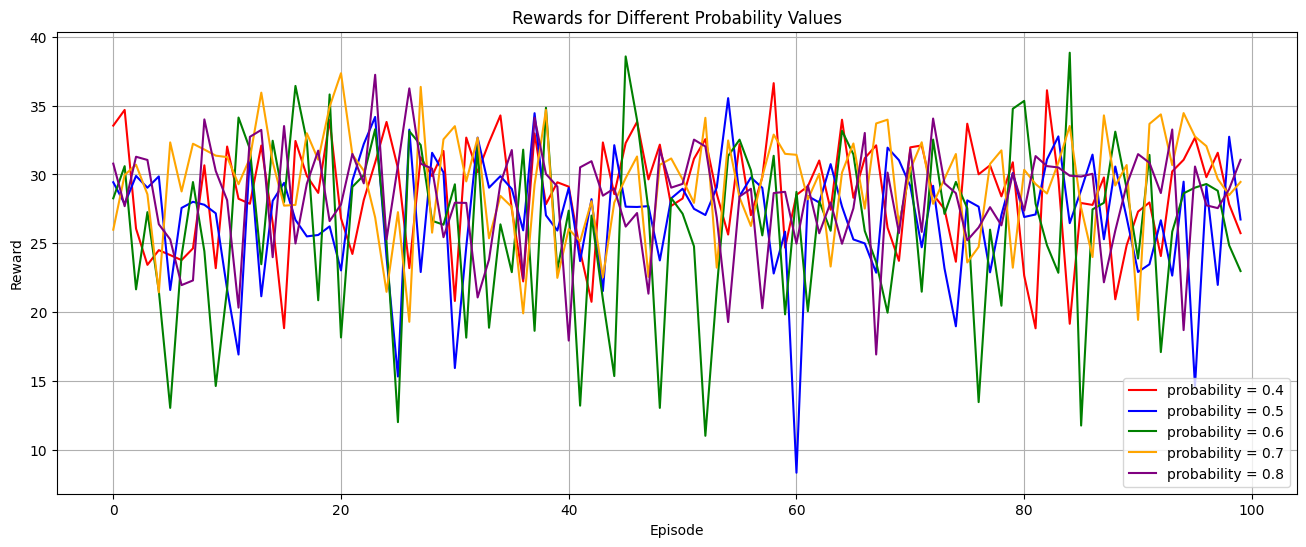

In [117]:
import matplotlib.pyplot as plt

rewards_list = [
    test_04_rewards,
    test_05_rewards,
    test_06_rewards,
    test_07_rewards,
    test_08_rewards
]
name_list = [
    "probability = 0.4",
    "probability = 0.5",
    "probability = 0.6",
    "probability = 0.7",
    "probability = 0.8"
]

# Define colors for each line
colors = ['red', 'blue', 'green', 'orange', 'purple']

# Create the line graph
plt.figure(figsize=(16, 6))

for i in range(len(rewards_list)):
    plt.plot(range(len(rewards_list[i])), rewards_list[i], label=name_list[i], color=colors[i])

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards for Different Probability Values')
plt.legend()
plt.grid(True)
plt.show()

In [118]:
import pandas as pd
# Create a DataFrame using the rewards list and name list
data = pd.DataFrame(rewards_list, index=name_list)

# Transpose the DataFrame to have the name list as columns
data = data.T

# Save the DataFrame to an Excel file
data.to_excel('rewards_probability.xlsx', index=False)

In [119]:
test_reward_mean_04 = np.mean(test_04_rewards)
test_reward_mean_05 = np.mean(test_05_rewards)
test_reward_mean_06 = np.mean(test_06_rewards)
test_reward_mean_07 = np.mean(test_07_rewards)
test_reward_mean_08 = np.mean(test_08_rewards)

In [120]:
mean_list = [test_reward_mean_04, test_reward_mean_05, test_reward_mean_06,
             test_reward_mean_07, test_reward_mean_08]

In [121]:
mean_list

[28.621929765292133,
 26.936053437155113,
 26.22436491459932,
 29.360456319346522,
 28.2272051673874]